# Import Libraries and Setup

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load and Prepare Data

In [2]:
# Load datasets
val_data = pd.read_csv('validation.csv')
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')

# Print dataset shapes
print(f"Validation data: {val_data.shape}")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

# Balance validation and test data
if len(test_data) >= 1000:
    half_test_data = test_data.iloc[1000:]
    test_data = test_data.iloc[:1000]
    val_data = pd.concat([val_data, half_test_data], axis=0)

print(f"New Validation data: {val_data.shape}")
print(f"New Test data: {test_data.shape}")

# Label mapping dictionary
labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)


Validation data: (2000, 2)
Training data: (16000, 2)
Test data: (2000, 2)
New Validation data: (3000, 2)
New Test data: (1000, 2)


# Data Exploration and Visualization

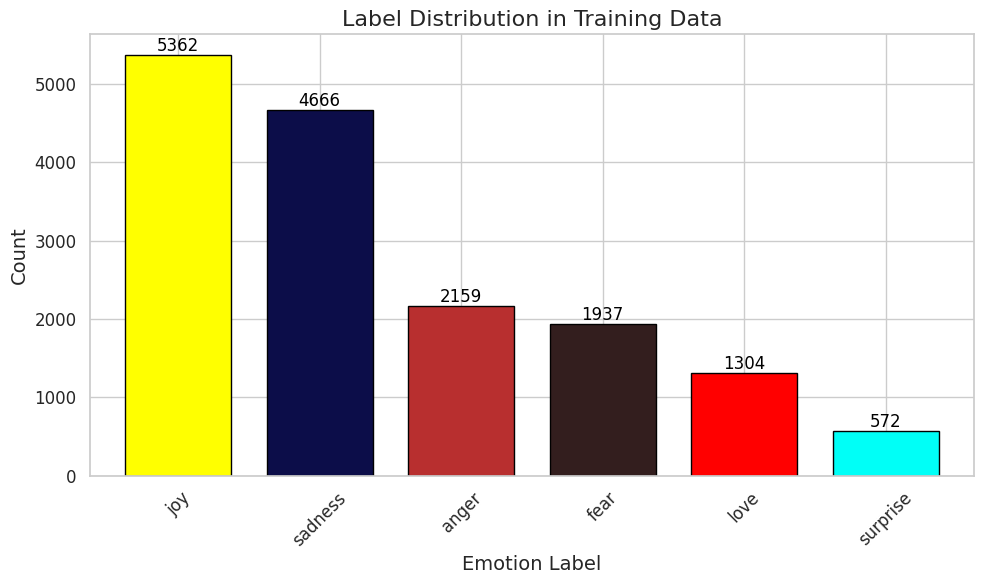

In [3]:
import seaborn as sns

# Set a more aesthetic style for the plot
sns.set(style="whitegrid")

# Create a better bar plot for label distribution
plt.figure(figsize=(10, 6))
ax = train_data['label_name'].value_counts().plot(kind='bar',
                                                   color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red', '#00fff7'],
                                                   edgecolor='black',
                                                   width=0.75)

# Title and labels
plt.title('Label Distribution in Training Data', fontsize=16)
plt.xlabel('Emotion Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the count on top of the bars
for i, v in enumerate(train_data['label_name'].value_counts()):
    ax.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=12, color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()




In [4]:
# Check for missing values
missing_train = train_data.isnull().sum()
missing_val = val_data.isnull().sum()
missing_test = test_data.isnull().sum()

print(f"Missing values in training data:\n{missing_train}")
print(f"Missing values in validation data:\n{missing_val}")
print(f"Missing values in test data:\n{missing_test}")

# Optional: if there are missing values, print a message
if missing_train.any() or missing_val.any() or missing_test.any():
    print("\nWarning: There are missing values in one or more datasets!")

Missing values in training data:
text          0
label         0
label_name    0
dtype: int64
Missing values in validation data:
text     0
label    0
dtype: int64
Missing values in test data:
text     0
label    0
dtype: int64


# Data Preprocessing

In [5]:
import nltk
nltk.download('stopwords')

# Initialize PorterStemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to preprocess data with stemming and stopword removal
def preprocess_text(text):
    tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to datasets
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
val_data['clean_text'] = val_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Create a tokenizer with combined training, validation, and test data
all_texts = train_data['clean_text'].tolist() + test_data['clean_text'].tolist() + val_data['clean_text'].tolist()
tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(f"Number of words without Stemming: {len(word_index)}")

# Function to preprocess data with stemming and tokenization
def preprocess_data(data):
    processed_data = []
    for _, row in data.iterrows():
        # Directly pass the clean_text (no split required here)
        sequence = tokenizer.texts_to_sequences([row['clean_text']])[0]
        processed_data.append([sequence, row['label']])
    return processed_data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of words without Stemming: 11598


# Build and Train Model

In [27]:
# Preprocess training and validation datasets
train_data_processed = preprocess_data(train_data)
val_data_processed = preprocess_data(val_data)

# Combine train and validation data for consistency in max sequence length
all_data_processed = train_data_processed + val_data_processed
max_seq_length = max(len(seq[0]) for seq in all_data_processed)

# Separate features and labels, and pad sequences
train_X = pad_sequences([row[0] for row in train_data_processed], maxlen=max_seq_length, padding='post')
train_y = np.array([row[1] for row in train_data_processed])

val_X = pad_sequences([row[0] for row in val_data_processed], maxlen=max_seq_length, padding='post')
val_y = np.array([row[1] for row in val_data_processed])

# Convert labels to one-hot encoding
num_classes = len(labels_dict)
train_y_one_hot = to_categorical(train_y, num_classes=num_classes)
val_y_one_hot = to_categorical(val_y, num_classes=num_classes)

print(f"Training set shape: {train_X.shape}, {train_y.shape}")
print(f"Validation set shape: {val_X.shape}, {val_y.shape}")

# Build an optimized bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=16000, output_dim=100, input_length=max_seq_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Training set shape: (16000, 35), (16000,)
Validation set shape: (3000, 35), (3000,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Train the model
history = model.fit(train_X, train_y_one_hot, epochs=12, validation_data=(val_X, val_y_one_hot), verbose=1)

Epoch 1/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3198 - loss: 1.6056 - val_accuracy: 0.3540 - val_loss: 1.5753
Epoch 2/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3359 - loss: 1.5796 - val_accuracy: 0.3533 - val_loss: 1.5173
Epoch 3/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3646 - loss: 1.3804 - val_accuracy: 0.5093 - val_loss: 1.0299
Epoch 4/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7494 - loss: 0.6570 - val_accuracy: 0.8873 - val_loss: 0.3386
Epoch 5/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9166 - loss: 0.2466 - val_accuracy: 0.9020 - val_loss: 0.2748
Epoch 6/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9453 - loss: 0.1521 - val_accuracy: 0.9047 - val_loss: 0.2822
Epoch 7/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9605 - loss: 0.1095 - val_accuracy: 0.9050 - val_loss: 0.2878
Epoch 8/12
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9612 - loss: 0.1013 - val

# Save and Evaluation




In [29]:
model.save('emotion_model.h5')


In [30]:
test_loss, test_accuracy = model.evaluate(test_X, test_y_one_hot, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("---------------------------------------------------------")

from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(test_y, y_pred_classes, target_names=list(labels_dict.values())))




Test Loss: 0.4134
Test Accuracy: 0.8900
---------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     sadness       0.93      0.96      0.95       295
         joy       0.88      0.91      0.89       337
        love       0.75      0.65      0.70        83
       anger       0.94      0.84      0.89       140
        fear       0.86      0.89      0.88       115
    surprise       0.72      0.70      0.71        30

    accuracy                           0.89      1000
   macro avg       0.85      0.83      0.84      1000
weighted avg       0.88      0.89      0.88      1000



In [37]:
import json

# Store metrics for each epoch
epoch_metrics = []
for epoch in range(len(history.history['loss'])):
    metrics = {
        'epoch': epoch + 1,
        'loss': history.history['loss'][epoch],
        'accuracy': history.history['accuracy'][epoch],
        'val_loss': history.history['val_loss'][epoch],
        'val_accuracy': history.history['val_accuracy'][epoch]
    }
    epoch_metrics.append(metrics)

# Get final test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_X, test_y_one_hot, verbose=0)

# Add final test metrics to the JSON
final_metrics = {
    'final_test_loss': test_loss,
    'final_test_accuracy': test_accuracy
}

# Append the final metrics to the list of epoch metrics
epoch_metrics.append(final_metrics)

# Save metrics to JSON file
with open('epoch_metrics.json', 'w') as f:
    json.dump(epoch_metrics, f, indent=4)

# Load the logged epoch metrics from the JSON file
with open('epoch_metrics.json', 'r') as f:
    epoch_metrics = json.load(f)

# Find best accuracy and loss
best_accuracy_epoch = max(epoch_metrics, key=lambda x: x.get('val_accuracy', 0))
best_loss_epoch = min(epoch_metrics, key=lambda x: x.get('val_loss', float('inf')))

# Print best accuracy and loss with corresponding epoch
print(f"Best Validation Accuracy: {best_accuracy_epoch['val_accuracy']} at Epoch {best_accuracy_epoch['epoch']}")
print(f"Best Validation Loss: {best_loss_epoch['val_loss']} at Epoch {best_loss_epoch['epoch']}")

# Print final model accuracy and loss on test data
print(f"Final Test Loss: {final_metrics['final_test_loss']:.4f}")
print(f"Final Test Accuracy: {final_metrics['final_test_accuracy']:.4f}")


Best Validation Accuracy: 0.9096666574478149 at Epoch 10
Best Validation Loss: 0.27475211024284363 at Epoch 5
Final Test Loss: 0.4134
Final Test Accuracy: 0.8900


# Visualization and Prediction

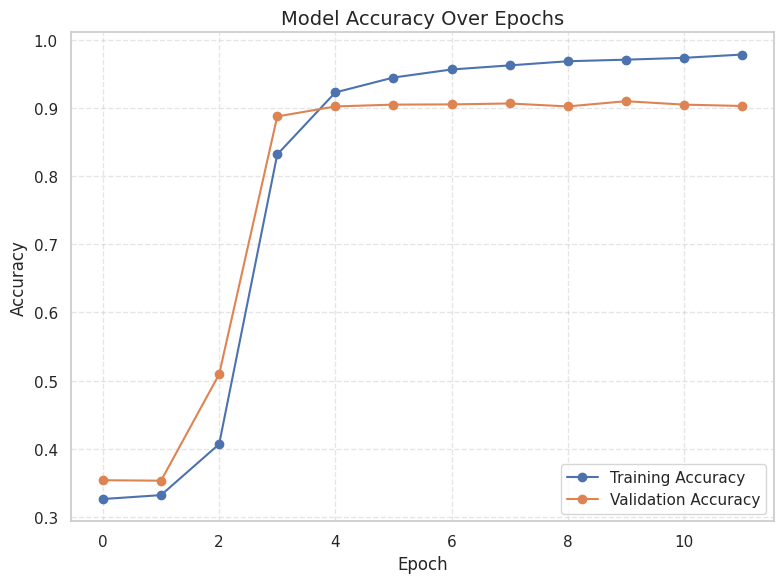

In [31]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




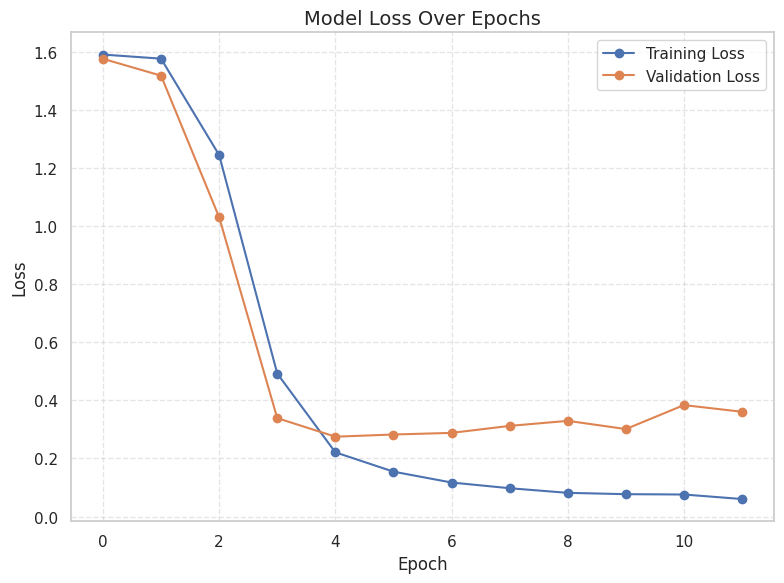

In [32]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], marker='o', label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# Function to predict on test data
def predict_text(text):
    cleaned_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])[0]
    sequence_padded = pad_sequences([sequence], maxlen=max_seq_length, padding='post')
    prediction = model.predict(sequence_padded, verbose=0)
    return np.argmax(prediction)

# Random predictions for testing
for _ in range(5):
    index = random.randint(0, len(test_data) - 1)
    predicted_class = predict_text(test_data['text'][index])
    actual_class = test_data['label'][index]
    print(f"\nPredicted: {labels_dict[predicted_class]}, Actual: {labels_dict[actual_class]}")

# Evaluate on entire test set
test_data_processed = preprocess_data(test_data)
test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])
test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

# Predict classes
y_pred = model.predict(test_X, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)



Predicted: joy, Actual: joy

Predicted: joy, Actual: joy

Predicted: anger, Actual: anger

Predicted: sadness, Actual: sadness

Predicted: joy, Actual: joy


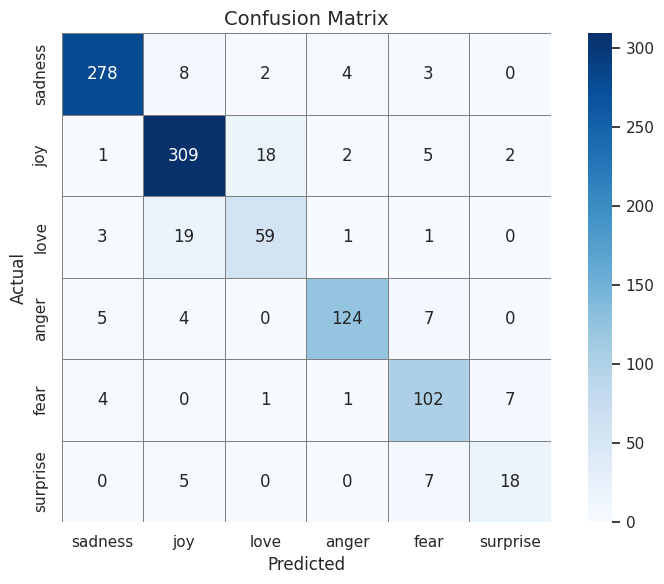

In [34]:
# Confusion matrix
cm = confusion_matrix(test_y, y_pred_classes)
df_cm = pd.DataFrame(cm, index=list(labels_dict.values()), columns=list(labels_dict.values()))

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()


## The End